# Save Results of all Models for a given Data and Model Version

Loop over all Folds and Models and save the results in a dataframe.  
Calculate a threshold for outcome prediction on the validation data (based on geometric mean) and apply it to the test data.  
Add a normalized prediction uncertainty based on the standard deviation of the predictions of the different models.  


## Load Libraries and Modules

In [1]:
%matplotlib inline

import os
import h5py
import pandas as pd
import numpy as np
import pickle as pkl
import time
    
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
from statsmodels.stats.proportion import proportion_confint
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras

print("TF  Version",tf.__version__)

Using TensorFlow backend.


TF  Version 2.2.0


In [2]:
# check and set path before loading modules
print(os.getcwd())
DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
if os.getcwd() != DIR:
    os.chdir(DIR)
    print(os.getcwd())

import functions_metrics as fm
import functions_model_definition as md
import functions_read_data as rdat
import Utils_maurice as utils

#ontram functions
from k_ontram_functions.ontram import ontram
from k_ontram_functions.ontram_loss import ontram_loss
from k_ontram_functions.ontram_metrics import ontram_acc, ontram_auc
from k_ontram_functions.ontram_predict import predict_ontram, get_parameters

/tf
/tf/notebooks/schnemau/xAI_stroke_3d


## Load Data and Results

In [3]:
version = "10Fold_CIBLSX_noTIA" 
layer_connection = "globalAveragePooling" 
last_activation = "linear" 
# Define Model Version
model_version = 2

# should csv be saved?
save_file = True

DATA_OUTPUT_DIR = DIR + "data/"

In [4]:
# Setup the paths for the result assembly
DATA_DIR = DIR + "data/" 
WEIGHT_DIR = DIR + "weights/" + version + "/"
#id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V0.csv", sep=",")
id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V3_mhs.csv", sep=",")
X = np.load(DATA_DIR + "prepocessed_dicom_3d.npy")
all_result_name = "all_tab_results_" + version + "_M" + str(model_version)
which_splits = list(range(0,10)) # 10 Fold
print(id_tab.shape)
print(X.shape)

(295, 14)
(407, 128, 128, 28)


In [5]:
print(WEIGHT_DIR)
print(all_result_name)

/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_CIBLSX_noTIA/
all_tab_results_10Fold_CIBLSX_noTIA_M2


In [6]:
#only load this data_loader for X_tab_train
(X_train, X_valid, X_test),(X_tab_train, X_tab_valid, X_tab_test), (y_train, y_valid, y_test) = rdat.split_data_tabular(id_tab, X, 1)


input_dim = (128, 128, 28, 1)
output_dim = 1
batch_size = 6
C = 2 

mbl = utils.img_model_linear_final(input_dim, output_dim)
mls = utils.mod_linear_shift(X_tab_train.shape[1])
model_3d = ontram(mbl, mls)             

model_3d.compile(optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
                                loss=ontram_loss(C, batch_size),
                                metrics=[ontram_acc(C, batch_size)])

In [7]:
model_nrs = list(range(5))

In [8]:
results_list = [] # test dataset results
valid_list = [] # validation datset results
betas = [] # validation datset results


for which_split in which_splits:
    (X_train, X_valid, X_test),(X_tab_train, X_tab_valid, X_tab_test), (y_train, y_valid, y_test) = rdat.split_data_tabular(id_tab, X, which_split)

    X_train = np.expand_dims(X_train, axis=-1)
    X_valid = np.expand_dims(X_valid, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)
    Y_train = to_categorical(y_train)
    Y_valid = to_categorical(y_valid)
    Y_test = to_categorical(y_test)
        
    test_data = tf.data.Dataset.from_tensor_slices((X_test, X_tab_test))
    test_labels = tf.data.Dataset.from_tensor_slices((Y_test))
    test_loader = tf.data.Dataset.zip((test_data, test_labels))
    test_dataset_pred = (test_loader.batch(len(X_test)))

    valid_data = tf.data.Dataset.from_tensor_slices((X_valid, X_tab_valid))
    valid_labels = tf.data.Dataset.from_tensor_slices((Y_valid))
    valid_loader = tf.data.Dataset.zip((valid_data, valid_labels))
    valid_dataset_pred = (valid_loader.batch(len(X_valid)))  
  
    results = id_tab[id_tab["fold" + str(which_split)] == "test"].copy()      
        
    results["test_split"] = which_split        
    
    validation_results = pd.DataFrame(
        {"test_split": which_split,
         "unfavorable": y_valid}
    )
       
    shift_params = []
    intercepts_test = []
    intercepts_val = []
    y_test_preds = []
    y_valid_preds = []
   
    for model_nr in model_nrs:        
        model_name = ("/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_CIBLSX/3D_CNN_avg_layer_binary_outcome_CIBLSX_split"+str(which_split)+"_ens"+str(model_nr)+"_M2.h5")
        
        
        model_3d.load_weights(model_name)
        
        #test
        predic =  predict_ontram(model_3d, data = test_dataset_pred)['pdf'][:,1]
        y_test_preds.append(predic.squeeze())
        results["y_pred_model_" + str(model_nr)] = y_test_preds[-1]

        #valid
        predicc = predict_ontram(model_3d, data = valid_dataset_pred)['pdf'][:,1]
        y_valid_preds.append(predicc.squeeze())
        validation_results["y_pred_model_" + str(model_nr)] = y_valid_preds[-1]   

        #ensembling        
        shift_params.append(get_parameters(model_3d)['shift'][0][0][0])
        #test
        preds_test = model_3d.predict(test_dataset_pred)
        intercepts_test.append(preds_test[:, 0])
        #valid
        preds_val = model_3d.predict(valid_dataset_pred)
        intercepts_val.append(preds_val[:, 0])

    
    y_test_preds = np.array(y_test_preds)
    y_valid_preds = np.array(y_valid_preds)

    #ensembling
    average_intercepts_test = np.mean(np.array(intercepts_test), axis=0)
    average_intercepts_val = np.mean(np.array(intercepts_val), axis=0)
    average_betas = np.mean(np.array(shift_params), axis=0)
    linprod_test = np.dot(X_tab_test, average_betas)
    linprod_val = np.dot(X_tab_valid, average_betas)

    betas.append(average_betas)

    results["y_pred_trafo_avg"] = 1-utils.sigmoid(average_intercepts_test - linprod_test.flatten())
    validation_results["y_pred_trafo_avg"] = 1-utils.sigmoid(average_intercepts_val - linprod_val.flatten())

    results_list.append(results)
    valid_list.append(validation_results)


In [9]:
betas

[array([[ 0.14915998],
        [-0.11038169],
        [ 0.08580706],
        [ 0.1508393 ],
        [-0.06165505],
        [ 0.20778087],
        [ 0.02095747],
        [ 0.29017332],
        [-0.12473676],
        [ 0.14374352],
        [-0.0215503 ],
        [ 0.01262397],
        [ 0.22063228]], dtype=float32),
 array([[ 0.21351881],
        [ 0.16534027],
        [ 0.16636743],
        [ 0.07847844],
        [-0.07132145],
        [ 0.00773802],
        [-0.09633209],
        [ 0.01263984],
        [-0.12939951],
        [ 0.04608852],
        [-0.23363988],
        [-0.03012793],
        [ 0.17292048]], dtype=float32),
 array([[ 0.09665549],
        [ 0.01524076],
        [ 0.12778941],
        [ 0.22154684],
        [-0.04083963],
        [ 0.10980892],
        [ 0.11033078],
        [-0.00942695],
        [ 0.06607433],
        [-0.0964026 ],
        [ 0.11544391],
        [-0.07606816],
        [ 0.14778537]], dtype=float32),
 array([[ 0.27703738],
        [ 0.09451835],
      

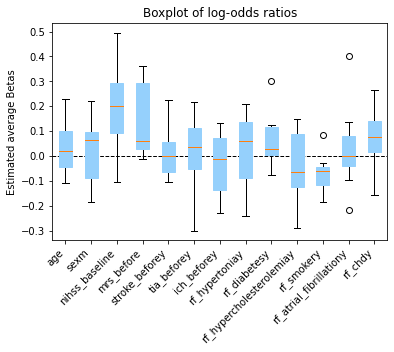

In [14]:
betas_reshaped = np.array(betas).reshape(10, 13)
# Set a color palette
palette = sns.color_palette("husl", n_colors=betas_reshaped.shape[0])

# Create a boxplot for each variable with light blue color
boxprops = dict(facecolor=sns.xkcd_rgb["light blue"], color=sns.xkcd_rgb["light blue"])
plt.boxplot(betas_reshaped, patch_artist=True, boxprops=boxprops)

# Add a horizontal line at 0
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Customize the plot (add labels, title, etc. as needed)
plt.xlabel('')
plt.ylabel('Estimated average Betas')
plt.title('Boxplot of log-odds ratios')

# Add x-axis tick labels with variable names
variable_names = ["age", "sexm", "nihss_baseline", "mrs_before",
                  "stroke_beforey", "tia_beforey", "ich_beforey", 
                  "rf_hypertoniay", "rf_diabetesy", "rf_hypercholesterolemiay", 
                  "rf_smokery", "rf_atrial_fibrillationy", "rf_chdy"]

plt.xticks(range(1, len(variable_names) + 1), variable_names, rotation=45, ha='right')

# Show the plot
plt.show()

## Calculate Threshold

Calculation of threshold for classification is done on validation data. Then applied to the test data.

 
---- Split 0 ----
 
Optimal Geometric Mean Threshold: 0.12199434590678926
Accuracy to beat: 0.7586206896551724
Accuracy: 0.8275862068965517
Spezifität:  0.8636363636363636
Sensitivität:  0.7142857142857143


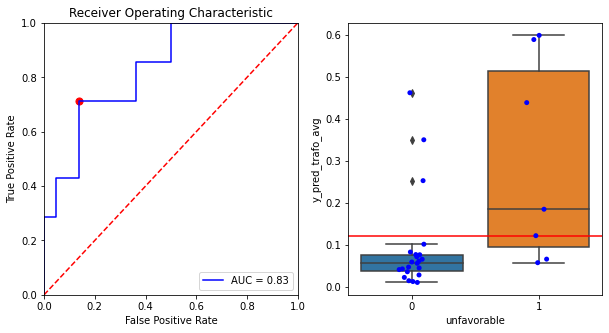

 
---- Split 1 ----
 
Optimal Geometric Mean Threshold: 0.2774662793338064
Accuracy to beat: 0.7586206896551724
Accuracy: 0.7931034482758621
Spezifität:  0.8181818181818181
Sensitivität:  0.7142857142857143


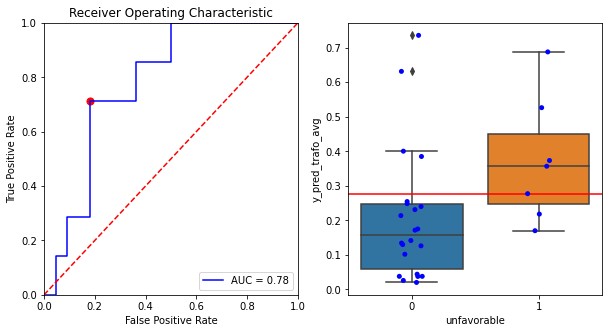

 
---- Split 2 ----
 
Optimal Geometric Mean Threshold: 0.476600884898005
Accuracy to beat: 0.7586206896551724
Accuracy: 0.896551724137931
Spezifität:  1.0
Sensitivität:  0.5714285714285714


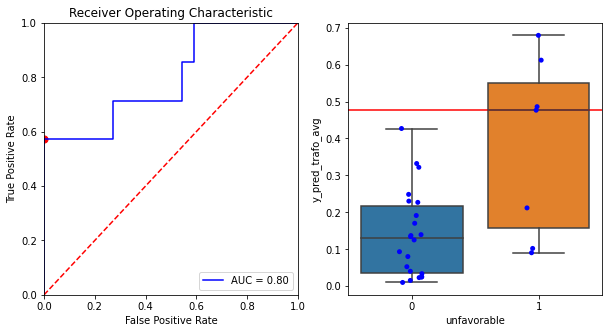

 
---- Split 3 ----
 
Optimal Geometric Mean Threshold: 0.1553829920676273
Accuracy to beat: 0.7586206896551724
Accuracy: 0.7241379310344828
Spezifität:  0.7272727272727273
Sensitivität:  0.7142857142857143


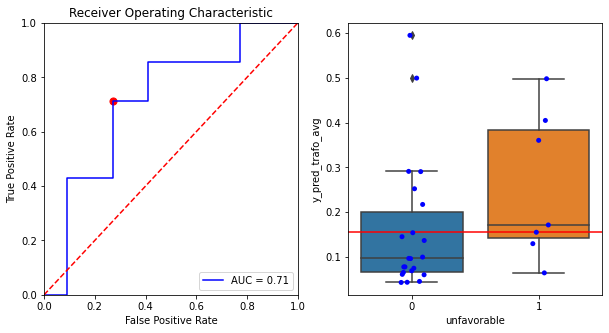

 
---- Split 4 ----
 
Optimal Geometric Mean Threshold: 0.19409810010185413
Accuracy to beat: 0.7586206896551724
Accuracy: 0.6896551724137931
Spezifität:  0.7272727272727273
Sensitivität:  0.5714285714285714


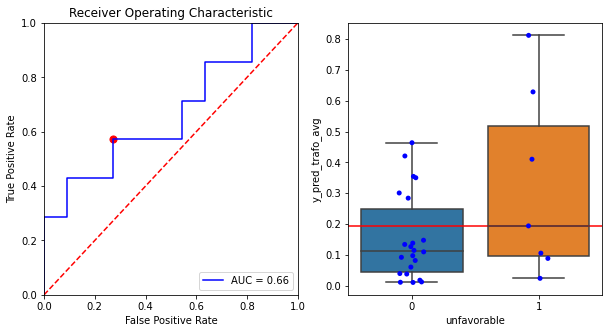

 
---- Split 5 ----
 
Optimal Geometric Mean Threshold: 0.25258052166393774
Accuracy to beat: 0.7666666666666666
Accuracy: 0.8333333333333334
Spezifität:  0.8695652173913043
Sensitivität:  0.7142857142857143


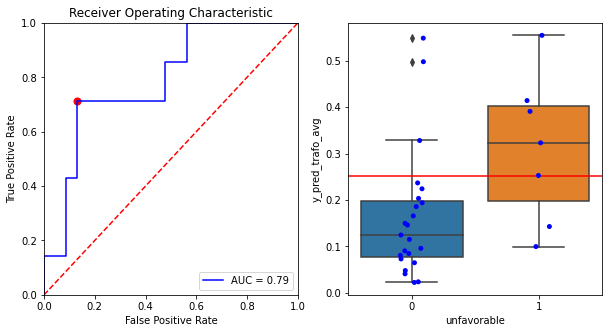

 
---- Split 6 ----
 
Optimal Geometric Mean Threshold: 0.21734356212144745
Accuracy to beat: 0.7666666666666666
Accuracy: 0.7333333333333333
Spezifität:  0.6521739130434783
Sensitivität:  1.0


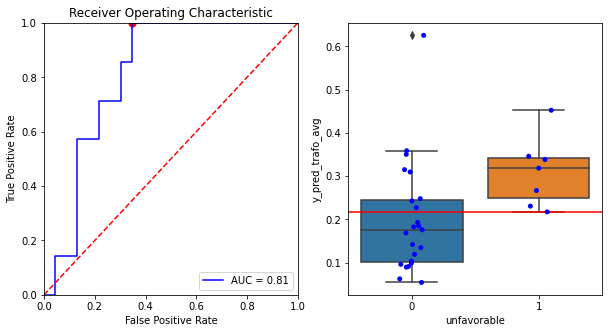

 
---- Split 7 ----
 
Optimal Geometric Mean Threshold: 0.11129696855483273
Accuracy to beat: 0.7666666666666666
Accuracy: 0.6
Spezifität:  0.4782608695652174
Sensitivität:  1.0


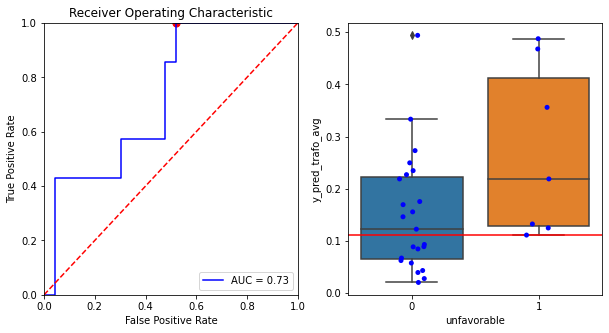

 
---- Split 8 ----
 
Optimal Geometric Mean Threshold: 0.1106509384327028
Accuracy to beat: 0.7666666666666666
Accuracy: 0.6333333333333333
Spezifität:  0.5652173913043479
Sensitivität:  0.8571428571428571


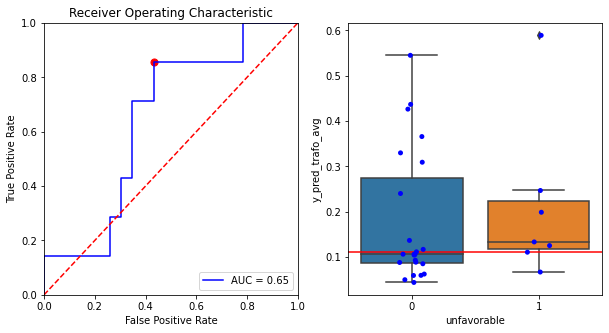

 
---- Split 9 ----
 
Optimal Geometric Mean Threshold: 0.12714221650332325
Accuracy to beat: 0.7666666666666666
Accuracy: 0.7333333333333333
Spezifität:  0.6521739130434783
Sensitivität:  1.0


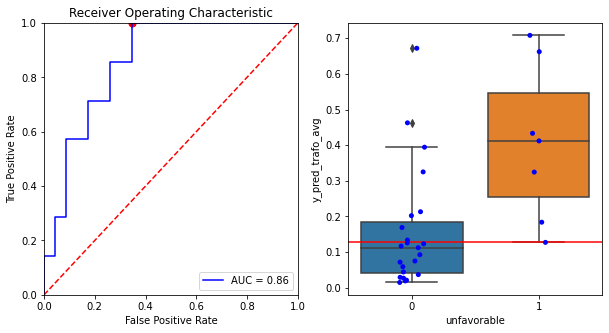

In [15]:
valid_thresholds = []

for i, validation_results in enumerate(valid_list):
    print(" ")
    print("---- Split " + str(which_splits[i]) + " ----")
    print(" ")
    
    y_org = validation_results["unfavorable"]
    y_pred = validation_results["y_pred_trafo_avg"]
    
    # calculate fpr, tpr and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    # calculate geometric mean of tpr and fpr to find best threshold
    gmean = np.sqrt(tpr * (1 - fpr))

    # Find the optimal threshold
    index = np.argmax(gmean)
    valid_thresholds.append(threshold[index])
    print("Optimal Geometric Mean Threshold: " + str(threshold[index]))
    
    # Calc Acc
    y_pred_label = (y_pred >= threshold[index]).squeeze()
    print("Accuracy to beat: " + str(1 - np.mean(y_org)))
    print("Accuracy: " + str(np.mean(y_pred_label == y_org)))
          
    print("Spezifität: ", 1-fpr[index])
    print("Sensitivität: ", tpr[index])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    
    # method I: plt
    ax1.title.set_text('Receiver Operating Characteristic')
    ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax1.scatter(fpr[index], tpr[index], color = "red", s = 50)
    ax1.legend(loc = 'lower right')
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    
    sns.boxplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        data = validation_results,
        ax = ax2)
    sns.stripplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        color = 'blue',
        data = validation_results,
        ax = ax2)
    ax2.axhline(y = threshold[index], color = "red")
    
    plt.show()

In [16]:
np.round(valid_thresholds,3)

array([0.122, 0.277, 0.477, 0.155, 0.194, 0.253, 0.217, 0.111, 0.111,
       0.127])

In [47]:
np.round(valid_thresholds,3)

array([0.195, 0.32 , 0.247, 0.165, 0.229, 0.428, 0.1  , 0.087, 0.145,
       0.22 ])

### Apply Threshold to Testdata

 
---- Split 0 ----
 
Accuracy to beat: 0.7666666666666666
Accuracy: 0.6666666666666666
Spezifität:  0.782608695652174
Sensitivität:  0.2857142857142857


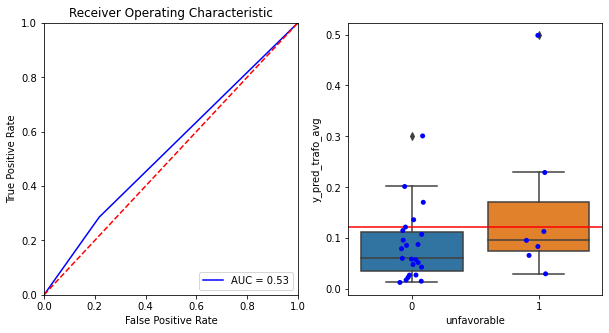

 
---- Split 1 ----
 
Accuracy to beat: 0.7666666666666666
Accuracy: 0.7
Spezifität:  0.782608695652174
Sensitivität:  0.42857142857142855


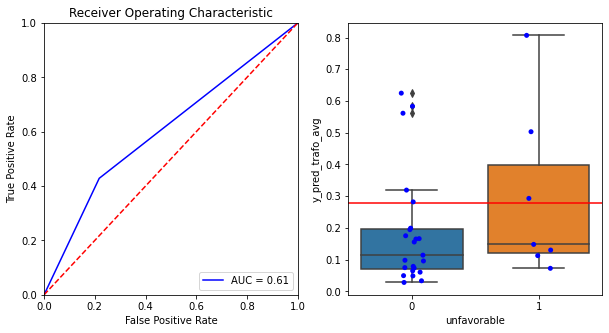

 
---- Split 2 ----
 
Accuracy to beat: 0.7666666666666666
Accuracy: 0.8333333333333334
Spezifität:  1.0
Sensitivität:  0.2857142857142857


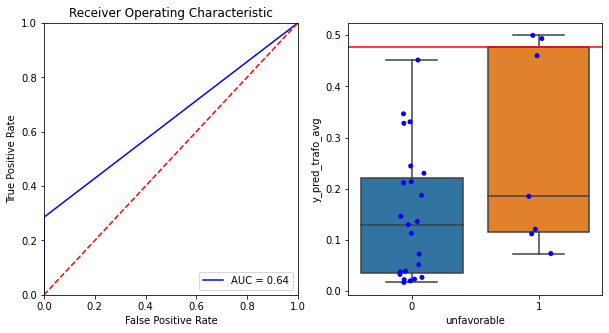

 
---- Split 3 ----
 
Accuracy to beat: 0.7666666666666666
Accuracy: 0.43333333333333335
Spezifität:  0.4782608695652174
Sensitivität:  0.2857142857142857


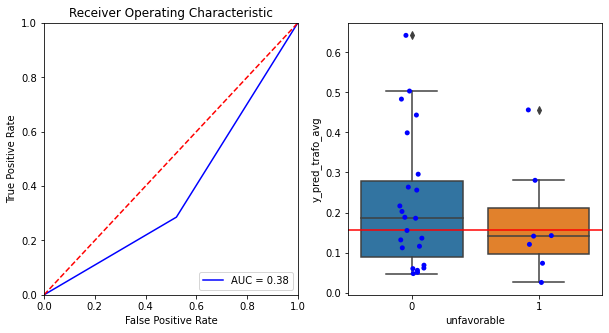

 
---- Split 4 ----
 
Accuracy to beat: 0.7666666666666666
Accuracy: 0.7333333333333333
Spezifität:  0.7391304347826086
Sensitivität:  0.7142857142857143


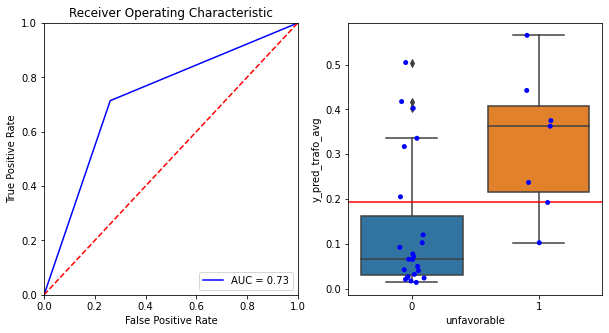

 
---- Split 5 ----
 
Accuracy to beat: 0.7586206896551724
Accuracy: 0.7931034482758621
Spezifität:  0.8636363636363636
Sensitivität:  0.5714285714285714


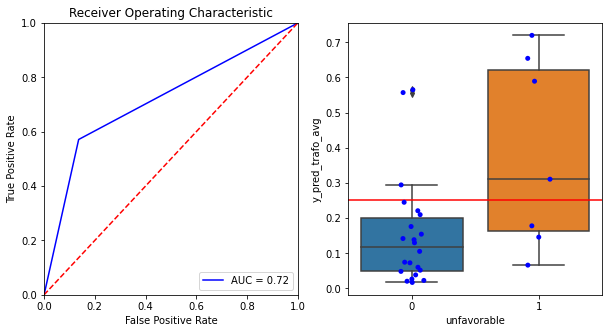

 
---- Split 6 ----
 
Accuracy to beat: 0.7586206896551724
Accuracy: 0.5862068965517241
Spezifität:  0.5909090909090908
Sensitivität:  0.5714285714285714


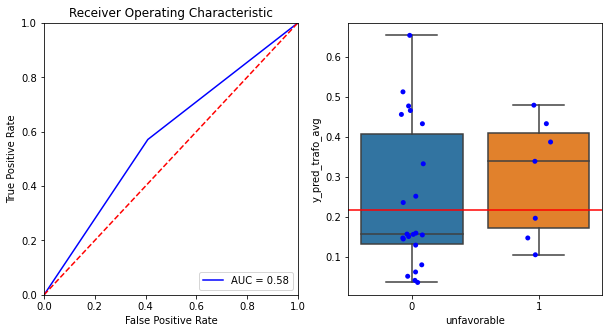

 
---- Split 7 ----
 
Accuracy to beat: 0.7586206896551724
Accuracy: 0.5517241379310345
Spezifität:  0.5
Sensitivität:  0.7142857142857143


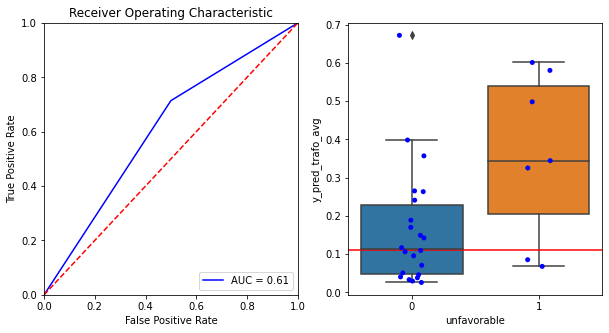

 
---- Split 8 ----
 
Accuracy to beat: 0.7586206896551724
Accuracy: 0.7241379310344828
Spezifität:  0.6363636363636364
Sensitivität:  1.0


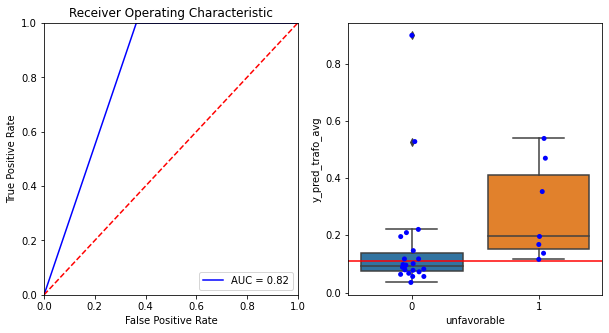

 
---- Split 9 ----
 
Accuracy to beat: 0.7586206896551724
Accuracy: 0.7241379310344828
Spezifität:  0.7272727272727273
Sensitivität:  0.7142857142857143


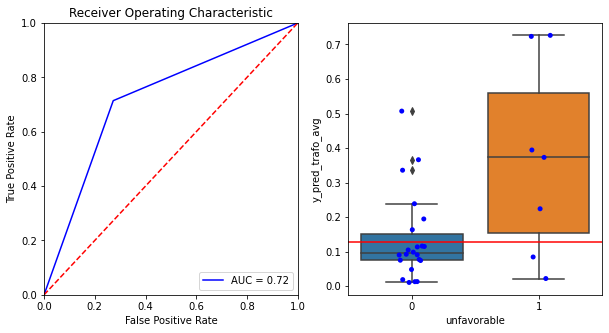

In [17]:
for i, results in enumerate(results_list):
    print(" ")
    print("---- Split " + str(which_splits[i]) + " ----")
    print(" ")

    results["threshold"] = valid_thresholds[i]
    results["y_pred_class"] = (results["y_pred_trafo_avg"] >= results["threshold"]).astype(int)
    
    y_org = results["unfavorable"]
    y_pred = results["y_pred_class"]
    
    # calculate fpr, tpr and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
      
    # Calc Acc
    print("Accuracy to beat: " + str(1 - np.mean(y_org)))
    print("Accuracy: " + str(np.mean(y_pred == y_org)))
          
    print("Spezifität: ", 1-fpr[1])
    print("Sensitivität: ", tpr[1])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    
    # method I: plt
    ax1.title.set_text('Receiver Operating Characteristic')
    ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax1.legend(loc = 'lower right')
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    
    sns.boxplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        data = results,
        ax = ax2)
    sns.stripplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        color = 'blue',
        data = results,
        ax = ax2)
    ax2.axhline(y = valid_thresholds[i], color = "red")
    
    plt.show()

#### Concat all Pandas and Analyze

In [18]:
all_results = pd.concat(results_list)
all_results.shape
all_results

,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,fold5,...,fold9,test_split,y_pred_model_0,y_pred_model_1,y_pred_model_2,y_pred_model_3,y_pred_model_4,y_pred_trafo_avg,threshold,y_pred_class
4,5,6,3.0,1,test,train,train,train,train,val,...,train,0,0.317742,0.031450,0.157671,0.108253,0.090348,0.113340,0.121994,0
14,15,22,0.0,0,test,train,train,train,train,val,...,train,0,0.043160,0.081941,0.468955,0.050117,0.005942,0.060642,0.121994,0
22,23,32,0.0,0,test,train,train,train,train,val,...,train,0,0.116508,0.147548,0.206775,0.079829,0.091422,0.122058,0.121994,1
30,31,41,0.0,0,test,train,train,train,train,val,...,train,0,0.074973,0.022241,0.050761,0.075406,0.041304,0.048562,0.121994,0
34,35,46,0.0,0,test,train,train,train,train,val,...,train,0,0.019331,0.009849,0.014069,0.011634,0.013404,0.013314,0.121994,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,356,498,1.0,0,train,train,train,train,val,train,...,test,9,0.020192,0.016364,0.016907,0.019493,0.001542,0.011135,0.127142,0
260,362,505,2.0,0,train,train,train,train,val,train,...,test,9,0.055480,0.051987,0.155956,0.080494,0.065137,0.075491,0.127142,0
265,367,510,4.0,1,train,train,train,train,val,train,...,test,9,0.099952,0.094529,0.071210,0.190484,0.031765,0.084873,0.127142,0
275,377,521,0.0,0,train,train,train,train,val,train,...,test,9,0.098031,0.071902,0.107646,0.012211,0.027216,0.048692,0.127142,0


In [19]:
y_org = all_results["unfavorable"]
y_pred_prob = all_results["y_pred_trafo_avg"]

metrics.log_loss(y_org, y_pred_prob)

0.519851192310495

Accuracy to beat: 0.7627118644067796
Accuracy: 0.6745762711864407
Spezifität:  0.7111111111111111
Sensitivität:  0.5571428571428572


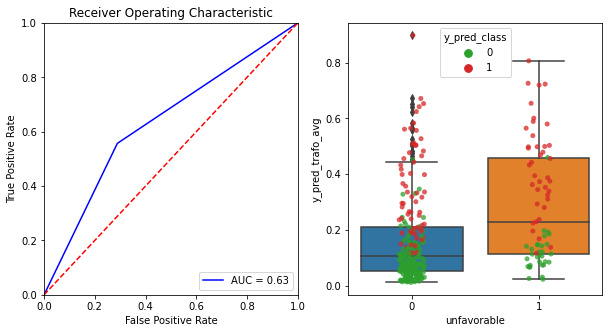

In [20]:
y_org = all_results["unfavorable"]
y_pred = all_results["y_pred_class"]

# calculate fpr, tpr and thresholds
fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# Calc Acc
y_pred_label = all_results["y_pred_class"]
print("Accuracy to beat: " + str(1 - np.mean(y_org)))
print("Accuracy: " + str(np.mean(y_pred_label == y_org)))

print("Spezifität: ", 1-fpr[1])
print("Sensitivität: ", tpr[1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# method I: plt
ax1.title.set_text('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

sns.boxplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    data = all_results,
    ax = ax2)
sns.stripplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    hue = 'y_pred_class',
    palette=["C2", "C3", "k"],
    data = all_results,
    alpha = 0.75,
    ax = ax2)
    

## Calculate Model Uncertainty

Use the standard deviation of the predictions as a measure of uncertainty. Then use min max normalization to scale the uncertainty between 0 and 1.  
Compare the uncertainty with the predictions

In [22]:
all_results["y_pred_std"] = all_results[["y_pred_model_" + str(i) for i in range(5)]].std(axis = 1)
all_results["y_pred_unc"] = (all_results["y_pred_std"] - all_results.y_pred_std.min()) / (
    all_results.y_pred_std.max() - all_results.y_pred_std.min())

[Text(0, 0.5, 'prediction uncertainty'), Text(0.5, 0, 'true class')]

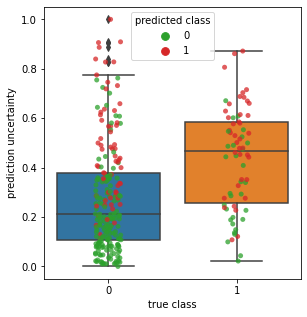

In [23]:
# Plot uncertainty
plt.figure(figsize = (4.6,5))
sns.boxplot(x = "unfavorable",
    y = "y_pred_unc",
    data = all_results)
g = sns.stripplot(x = "unfavorable",
    y = "y_pred_unc",
    hue = 'y_pred_class',
    alpha = 0.75,
    palette=["C2", "C3"],
    data = all_results)
plt.legend(title='predicted class', loc='upper center')
g.set(xlabel='true class', ylabel='prediction uncertainty')

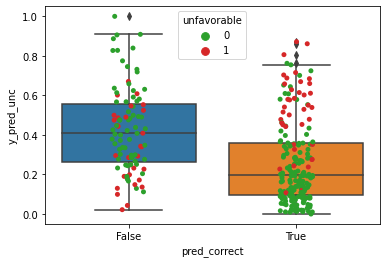

In [24]:
all_results["pred_correct"] = all_results["y_pred_class"] == all_results["unfavorable"] 

sns.boxplot(x = "pred_correct",
    y = "y_pred_unc",
    data = all_results)
sns.stripplot(x = "pred_correct",
    y = "y_pred_unc",
    hue = 'unfavorable',
    palette=["C2", "C3"],
    data = all_results)

### Save results

Delete threshold 1 because mulitple different thresholds does not make sense.

In [25]:
save_file = True

In [28]:
if save_file:
    all_results.to_csv(DATA_OUTPUT_DIR + all_result_name + "_dyn_threshold" + ".csv",  index=False) # rename output file!!!!

# Graveyard

In [ ]:
'''model_name = ("/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_CIBLSX/3d_cnn_binary_model_split" + "CIB_LSX" + str(1) + 
                    "_normalized_avg_layer_paper_model_" + last_activation + 
                    "_activation_" + str(1) + "_" + str(1) + ".h5")        

model_3d.load_weights(model_name)        

test_data = tf.data.Dataset.from_tensor_slices((X_test, X_tab_test))
test_labels = tf.data.Dataset.from_tensor_slices((to_categorical(y_test)))
test_loader = tf.data.Dataset.zip((test_data, test_labels))
test_dataset_pred = (test_loader.batch(len(X_test)))
prediccc =  predict_ontram(model_3d, data = test_dataset_pred)
preds = model_3d.predict(test_dataset_pred)
preds[:, 0]
'''